# Perform Textual Embedding

## Loading Credentials

In [1]:
import json
import os
import pandas as pd

data_path = '../Mikey_data/'
if os.path.exists(data_path):
    os.chdir(data_path)
    print('Changed directory to data path:', os.getcwd())
else:
    print('Data path does not exist:', data_path)

with open('credentials.json', 'r') as file:
    credentials = json.load(file)

db_server_name = credentials['clickhouse']['server_name']
db_username = credentials['clickhouse']['username']
db_password = credentials['clickhouse']['password']

Changed directory to data path: /home/mfin7037_best_students/code/Mikey_data


## Test Connection

In [98]:
from clickhouse_driver import Client

client = Client(host=db_server_name, user=db_username, password=db_password)

try:
    result = client.execute('SELECT version()')
    print("Connected to ClickHouse server. Version:", result[0][0])
except Exception as e:
    print("Failed to connect to ClickHouse server:", e)

Connected to ClickHouse server. Version: 25.4.1.1926


In [99]:
client.execute('describe tiingo.news')

[('crawlDate', 'Nullable(String)', '', '', '', '', ''),
 ('description', 'Nullable(String)', '', '', '', '', ''),
 ('id', 'Nullable(Float64)', '', '', '', '', ''),
 ('publishedDate', 'Nullable(String)', '', '', '', '', ''),
 ('source', 'Nullable(String)', '', '', '', '', ''),
 ('tags', 'Nullable(String)', '', '', '', '', ''),
 ('ticker', 'Nullable(String)', '', '', '', '', ''),
 ('tickers_all', 'Nullable(String)', '', '', '', '', ''),
 ('title', 'Nullable(String)', '', '', '', '', ''),
 ('tld', 'Nullable(String)', '', '', '', '', ''),
 ('url', 'Nullable(String)', '', '', '', '', '')]

In [105]:
client.execute('show tables from tiingo_iex')

[('bars_5minute',),
 ('crypto_1hour_consolidated',),
 ('crypto_1hour_exchangelevel',),
 ('crypto_1minute_consolidated',),
 ('crypto_1minute_exchangelevel',),
 ('status_scrape',),
 ('status_scrape_5min',),
 ('tickerlist_20240512',),
 ('tickerlist_20250312',)]

In [110]:
client.execute('describe tiingo_iex.crypto_1minute_consolidated')

[('ticker', 'Nullable(String)', '', '', '', '', ''),
 ('baseCurrency', 'Nullable(String)', '', '', '', '', ''),
 ('quoteCurrency', 'Nullable(String)', '', '', '', '', ''),
 ('date', 'Nullable(Float64)', '', '', '', '', ''),
 ('open', 'Nullable(Float64)', '', '', '', '', ''),
 ('high', 'Nullable(Float64)', '', '', '', '', ''),
 ('low', 'Nullable(Float64)', '', '', '', '', ''),
 ('close', 'Nullable(Float64)', '', '', '', '', ''),
 ('volume', 'Nullable(Float64)', '', '', '', '', ''),
 ('volumeNotional', 'Nullable(Float64)', '', '', '', '', ''),
 ('tradesDone', 'Nullable(Float64)', '', '', '', '', '')]

In [ ]:
client.execute("select * from tiingo_iex.crypto_1minute_consolidated where ticker = 'btc' limit 5")

[('adausd',
  'ada',
  'usd',
  1514764800.0,
  0.7034001,
  0.7034001,
  0.7034001,
  0.7034001,
  1500.28958579,
  1055.3038446736446,
  2.0),
 ('adausd',
  'ada',
  'usd',
  1514764860.0,
  0.7034001,
  0.70999953,
  0.7,
  0.7,
  12593.08094499,
  8815.156661493,
  21.0),
 ('adausd',
  'ada',
  'usd',
  1514764920.0,
  0.7,
  0.70999933,
  0.699,
  0.699,
  31338.98535672,
  21905.95076434728,
  23.0),
 ('adausd',
  'ada',
  'usd',
  1514764980.0,
  0.7099,
  0.7099,
  0.7099,
  0.7099,
  1682.64101742,
  1194.506858266458,
  2.0),
 ('adausd',
  'ada',
  'usd',
  1514765040.0,
  0.699,
  0.699,
  0.699,
  0.699,
  2126.12687217,
  1486.1626836468297,
  3.0)]

## Filter Tiingo Data

In [4]:
import pandas as pd
from clickhouse_driver import Client

client = Client(host=db_server_name, user=db_username, password=db_password)

# query btc news
query = f"""
SELECT  distinct(id) as id,
        description,
        ticker,
        tickers_all,
        title,
        parseDateTimeBestEffort(publishedDate) AS date 
FROM tiingo.news
WHERE ticker in ('btc', 'eth', 'doge', 'sol')
AND date >= '2016-01-01'
AND LENGTH(description) <= 8192
"""

# fetch the result directly as a pandas DataFrame directly
news_data_df = client.query_dataframe(query)

In [5]:
news_data_df

id                                        description ticker  \
0      46018628.0  Bitcoin (CRYPTO: BTC), the world’s oldest cryp...    btc   
1      22921263.0  Ethan Allen Interiors (NYSE:ETH) is scheduled ...    eth   
2      22910463.0  Today, we'll introduce the concept of the P/E ...    eth   
3      22902421.0  Ethan Allen Interiors (NYSE:ETH) will issue it...    eth   
4      14140567.0  Siacoin (CURRENCY:SC) traded down 3.5% against...    btc   
...           ...                                                ...    ...   
23224  11401988.0  SOILcoin (CURRENCY:SOIL) traded 1.4% higher ag...    btc   
23225  11401994.0  Bitcoin Cash (CURRENCY:BCH) traded 1.4% lower ...    btc   
23226  41887075.0  ReneSola (NYSE:SOL – Get Rating) was downgrade...    sol   
23227  22536649.0  Ethan Allen Interiors Inc. (NYSE:ETH) – Analys...    eth   
23228   4583498.0  American depository receipts of Asian stocks w...    sol   

                 tickers_all  \
0                 btc/ko/mcd   
1                        eth   
2                        eth   
3                        eth   
4            bch/btc/btg/ltc   
...                      ...   
23224   bch/btc/btg/ltc/soil   
23225    atb/bch/btc/trc/uno   
23226  db/gs/gsf/gsj/sol/sol   
23227                eth/key   
23228  atai/bzun/osn/smi/sol   

                                                   title                date  
0      Bitcoin Drops Further To This Level, Here Are ... 2022-07-26 08:25:11  
1         Ethan Allen Interiors Q2 2020 Earnings Preview 2020-02-04 06:35:00  
2      Is Ethan Allen Interiors Inc.’s (NYSE:ETH) Hig... 2020-02-03 20:36:59  
3      Ethan Allen Interiors (ETH) Set to Announce Qu... 2020-02-03 16:24:00  
4      Siacoin (CRYPTO:SC) 1-Day Trading Volume Hits ... 2018-12-03 22:31:34  
...                                                  ...                 ...  
23224    SOILcoin (SOIL) Price Hits $0.0195 on Exchanges 2018-06-10 06:35:14  
23225    Bitcoin Cash Price Up 2.4% Over Last Week (BCH) 2018-06-10 06:35:26  
23226  Zacks Investment Research Lowers ReneSola (NYS... 2022-02-24 00:15:57  
23227  Ethan Allen Interiors Inc. (NYSE:ETH) to Post ... 2020-01-16 15:02:42  
23228          Asian ADRs Move Higher in Tuesday Trading 2017-02-07 23:44:02  

[23229 rows x 6 columns]

## LLM Embeddings
- Mistral AI: https://docs.mistral.ai/capabilities/embeddings/
- sentence-transformers: all-MiniLM-L6-v2
    - Lightweight (23M parameters) with 384-dimensional embeddings.
    - Fine-tuned for semantic tasks (clustering, similarity search).
    - Automatically applies mean pooling during inference.

### Example

In [86]:
from mistralai import Mistral

api_key = credentials['api_key']['mistral']
mistral_client = Mistral(api_key=api_key)

model = "mistral-embed"
text = "Embed this sentence."

embeddings_batch_response= mistral_client.embeddings.create(
    model=model,
    inputs=text,
)

print(embeddings_batch_response.data[0].embedding)
print('length of embedding:', len(embeddings_batch_response.data[0].embedding))

[-0.01666259765625, 0.06982421875, 0.031494140625, 0.01284027099609375, 0.020660400390625, 0.0096435546875, 0.025787353515625, 0.0018548965454101562, -0.00867462158203125, -0.0087890625, -0.039703369140625, 0.058441162109375, -0.0255584716796875, 0.00775909423828125, -0.02886962890625, 0.0404052734375, 0.05499267578125, 0.0260162353515625, 0.03173828125, 0.023284912109375, -0.05682373046875, -0.0157470703125, -0.061614990234375, 0.01226806640625, -0.046112060546875, -0.0270538330078125, -0.00775909423828125, -0.03790283203125, -0.0401611328125, 0.0010061264038085938, 0.0238494873046875, -0.030120849609375, 0.0303497314453125, -0.002353668212890625, -0.0120391845703125, -0.036285400390625, -0.0330810546875, -0.044952392578125, 0.0133514404296875, 0.00186920166015625, 0.00969696044921875, -0.00034046173095703125, -0.0308074951171875, -0.0230560302734375, -0.024871826171875, -0.0296783447265625, 0.00447845458984375, -0.0279541015625, -0.0176849365234375, -0.0330810546875, 0.00987243652343

### Run Embeddings

In [2]:
from mistralai import Mistral
import time
from tqdm import tqdm

def run_mistral_embedding(df: pd.DataFrame, api_key, model: str = 'mistral-embed', batch_size: int = 10) -> None:
    mistral_client = Mistral(api_key=api_key)

    # Initialize new column
    df['mistral_embedding'] = None

    # Process in batches
    for start_idx in tqdm(range(0, len(df), batch_size)):
        end_idx = min(start_idx + batch_size, len(df))
        batch_texts = df.loc[start_idx:end_idx - 1, 'description'].tolist()

        embeddings_batch_response = mistral_client.embeddings.create(
            model=model,
            inputs=batch_texts,
        )

        # Write result embeddings values to df
        for i, embedding in enumerate(embeddings_batch_response.data):
            df.loc[start_idx + i, 'mistral_embedding'] = str(embedding.embedding)

        # request rate is limited, mistral is annoying
        time.sleep(2)

In [4]:
import pandas as pd
import requests

def run_miniLM_embedding(df: pd.DataFrame, api_token: str, batch_size=10, max_retries=3) -> None:
    """
    Process text embeddings in batches using the sentence-transformers/all-MiniLM-L6-v2 model.
    
    Args:
        df: pandas DataFrame containing the text data
        api_token: Hugging Face API token
        batch_size: number of texts to process in each batch
        max_retries: maximum number of retry attempts per batch
    """

    model_id = "sentence-transformers/all-MiniLM-L6-v2"
    api_url = f"https://api-inference.huggingface.co/pipeline/feature-extraction/{model_id}"
    headers = {"Authorization": f"Bearer {api_token}"}

    # Initialize new column
    df['embeddings'] = None

    # Process in batches
    for start_idx in tqdm(range(0, len(df), batch_size)):
        end_idx = min(start_idx + batch_size, len(df))
        batch_texts = df.loc[start_idx:end_idx - 1, 'description'].tolist()

        # Try to get embeddings with retries
        for attempt in range(max_retries):
            response = requests.post(
                api_url, 
                headers=headers, 
                json={
                    "inputs": batch_texts,
                    "options": {
                        "wait_for_model": True,
                        "use_cache": False 
                    }
                }
            )
            
            if response.status_code == 200:
                embeddings = response.json()
                # Store embeddings in DataFrame
                for i, embedding in enumerate(embeddings):
                    df.loc[start_idx + i, 'embeddings'] = str(embedding)
            elif response.status_code == 503 and attempt < max_retries - 1:
                # Model loading - wait with exponential backoff
                wait_time = 2 ** attempt
                print(f"Model loading, retrying in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"Embedding failed for batch {start_idx}-{end_idx}: {response.text}")
                continue

## Analysis

### Data Prep

In [5]:
import os
import pandas as pd

data_path = '../Mikey_data/'
if os.path.exists(data_path):
    os.chdir(data_path)
    print('Changed directory to data path:', os.getcwd())
else:
    print('Data path does not exist:', data_path)

Changed directory to data path: /home/mfin7037_best_students/code/Mikey_data


#### Prepare Mistral

In [6]:
import pandas as pd
from clickhouse_driver import Client
import gc
import json

# load calculated embedding values from a saved file
mistral_embed_df = pd.read_parquet('mistral_embeddings.parquet')

# query news data
client = Client(host=db_server_name, user=db_username, password=db_password)

query = f"""
SELECT  distinct(id) as id,
        description,
        ticker,
        tickers_all,
        title,
        parseDateTimeBestEffort(publishedDate) AS date 
FROM tiingo.news
WHERE ticker in ('btc', 'eth', 'doge', 'sol')
AND LENGTH(description) <= 8192
"""

# fetch the result directly as a pandas DataFrame directly
news_data_df = client.query_dataframe(query)

# Merge the two DataFrames on the 'id' column
news_mistral_embed_df = pd.merge(news_data_df, mistral_embed_df, on='id', how='left')

# release memory
del mistral_embed_df
del news_data_df
gc.collect()

news_mistral_embed_df

id                                        description ticker  \
0      15232749.0  FujiCoin (CURRENCY:FJC) traded down 0.3% again...    btc   
1      15233306.0  Dollarcoin (CURRENCY:DLC) traded flat against ...    btc   
2      15233420.0  Infinity Economics (CURRENCY:XIN) traded up 5....    btc   
3      15234056.0  Steem (CURRENCY:STEEM) traded up 0.3% against ...    btc   
4      10608904.0  Aidos Kuneen (CURRENCY:ADK) traded 4.1% higher...    btc   
...           ...                                                ...    ...   
23878  11401988.0  SOILcoin (CURRENCY:SOIL) traded 1.4% higher ag...    btc   
23879  11401994.0  Bitcoin Cash (CURRENCY:BCH) traded 1.4% lower ...    btc   
23880  41887075.0  ReneSola (NYSE:SOL – Get Rating) was downgrade...    sol   
23881  22536649.0  Ethan Allen Interiors Inc. (NYSE:ETH) – Analys...    eth   
23882   4583498.0  American depository receipts of Asian stocks w...    sol   

                    tickers_all  \
0               bch/btc/btg/ltc   
1           atb/bch/btc/trc/uno   
2       bch/btc/emc/ppc/uno/xin   
3       atb/bch/btc/trc/unb/uno   
4      adk/bch/btc/btg/ltc/nano   
...                         ...   
23878      bch/btc/btg/ltc/soil   
23879       atb/bch/btc/trc/uno   
23880     db/gs/gsf/gsj/sol/sol   
23881                   eth/key   
23882     atai/bzun/osn/smi/sol   

                                                   title                date  \
0      FujiCoin (FJC) Tops One Day Trading Volume of ... 2019-02-10 03:12:40   
1             Dollarcoin (DLC) 24-Hour Volume Tops $0.00 2019-02-10 04:40:40   
2      Infinity Economics Price Reaches $0.0013 on Ex... 2019-02-10 05:34:46   
3      Steem (STEEM) One Day Trading Volume Tops $833... 2019-02-10 09:06:42   
4      Aidos Kuneen Tops 24-Hour Trading Volume of $5... 2018-05-08 11:58:53   
...                                                  ...                 ...   
23878    SOILcoin (SOIL) Price Hits $0.0195 on Exchanges 2018-06-10 06:35:14   
23879    Bitcoin Cash Price Up 2.4% Over Last Week (BCH) 2018-06-10 06:35:26   
23880  Zacks Investment Research Lowers ReneSola (NYS... 2022-02-24 00:15:57   
23881  Ethan Allen Interiors Inc. (NYSE:ETH) to Post ... 2020-01-16 15:02:42   
23882          Asian ADRs Move Higher in Tuesday Trading 2017-02-07 23:44:02   

                                       mistral_embedding  
0      [-0.0196380615234375, 0.00994110107421875, 0.0...  
1      [-0.019775390625, 0.0135498046875, 0.001121520...  
2      [0.020355224609375, 0.0196990966796875, 0.0591...  
3      [-0.024078369140625, 0.04144287109375, 0.03863...  
4      [-0.01113128662109375, 0.027618408203125, 0.06...  
...                                                  ...  
23878  [-0.0028476715087890625, 0.01058197021484375, ...  
23879  [-0.006984710693359375, 0.043975830078125, 0.0...  
23880  [-0.0078887939453125, 0.01297760009765625, -0....  
23881  [-0.042999267578125, 0.038543701171875, 0.0308...  
23882  [0.005245208740234375, 0.035247802734375, 0.03...  

[23883 rows x 7 columns]

In [7]:
import duckdb
# some data filtering, let's focus on btc first
# 1. ticker = btc
# 2. after 2016-01-01
# 3. description is not empty

filter_df = duckdb.query(
    """
    SELECT *
    FROM news_mistral_embed_df
    WHERE ticker = 'btc'
    AND date >= '2018-01-01'
    AND description != ''
    AND description != ' '
    """
).fetchdf()

filter_df

id                                        description ticker  \
0      15232749.0  FujiCoin (CURRENCY:FJC) traded down 0.3% again...    btc   
1      15233306.0  Dollarcoin (CURRENCY:DLC) traded flat against ...    btc   
2      15233420.0  Infinity Economics (CURRENCY:XIN) traded up 5....    btc   
3      15234056.0  Steem (CURRENCY:STEEM) traded up 0.3% against ...    btc   
4      10608904.0  Aidos Kuneen (CURRENCY:ADK) traded 4.1% higher...    btc   
...           ...                                                ...    ...   
17200  11399896.0  Peercoin (CURRENCY:PPC) traded 0.8% higher aga...    btc   
17201  11400985.0  Siacoin (CURRENCY:SC) traded down 4.8% against...    btc   
17202  11401515.0  SmartCash (CURRENCY:SMART) traded up 2.8% agai...    btc   
17203  11401988.0  SOILcoin (CURRENCY:SOIL) traded 1.4% higher ag...    btc   
17204  11401994.0  Bitcoin Cash (CURRENCY:BCH) traded 1.4% lower ...    btc   

                    tickers_all  \
0               bch/btc/btg/ltc   
1           atb/bch/btc/trc/uno   
2       bch/btc/emc/ppc/uno/xin   
3       atb/bch/btc/trc/unb/uno   
4      adk/bch/btc/btg/ltc/nano   
...                         ...   
17200       bch/btc/emc/ppc/uno   
17201           bch/btc/btg/ltc   
17202           bch/btc/btg/ltc   
17203      bch/btc/btg/ltc/soil   
17204       atb/bch/btc/trc/uno   

                                                   title                date  \
0      FujiCoin (FJC) Tops One Day Trading Volume of ... 2019-02-10 03:12:40   
1             Dollarcoin (DLC) 24-Hour Volume Tops $0.00 2019-02-10 04:40:40   
2      Infinity Economics Price Reaches $0.0013 on Ex... 2019-02-10 05:34:46   
3      Steem (STEEM) One Day Trading Volume Tops $833... 2019-02-10 09:06:42   
4      Aidos Kuneen Tops 24-Hour Trading Volume of $5... 2018-05-08 11:58:53   
...                                                  ...                 ...   
17200      Peercoin  Trading 0.5% Lower  This Week (PPC) 2018-06-10 01:28:45   
17201  Siacoin (SC) One Day Trading Volume Reaches $1... 2018-06-10 03:53:46   
17202  SmartCash Reaches Market Capitalization of $92... 2018-06-10 05:25:43   
17203    SOILcoin (SOIL) Price Hits $0.0195 on Exchanges 2018-06-10 06:35:14   
17204    Bitcoin Cash Price Up 2.4% Over Last Week (BCH) 2018-06-10 06:35:26   

                                       mistral_embedding  
0      [-0.0196380615234375, 0.00994110107421875, 0.0...  
1      [-0.019775390625, 0.0135498046875, 0.001121520...  
2      [0.020355224609375, 0.0196990966796875, 0.0591...  
3      [-0.024078369140625, 0.04144287109375, 0.03863...  
4      [-0.01113128662109375, 0.027618408203125, 0.06...  
...                                                  ...  
17200  [-0.038330078125, 0.0133514404296875, 0.032226...  
17201  [-0.0207672119140625, 0.0007457733154296875, 0...  
17202  [-0.0168304443359375, -0.0006341934204101562, ...  
17203  [-0.0028476715087890625, 0.01058197021484375, ...  
17204  [-0.006984710693359375, 0.043975830078125, 0.0...  

[17205 rows x 7 columns]

In [9]:
# ready to merge btc daily return
btc_daily = pd.read_pickle('btc_daily.pkl')
btc_daily.reset_index(inplace=True)

# some processing
btc_daily.rename(columns={'Open time': 'date'}, inplace=True)
btc_daily.sort_values(by='date', inplace=True)
btc_daily['return'] = btc_daily['Close'].pct_change()

btc_daily['volatility'] = (btc_daily['High'] - btc_daily['Low']) / btc_daily['Close']
btc_daily

date      Open      High       Low     Close        Volume  \
0    2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377   
1    2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264   
2    2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763   
3    2017-08-20   4120.98   4211.08   4032.62   4086.29    467.083022   
4    2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060   
...         ...       ...       ...       ...       ...           ...   
2753 2025-03-01  84349.95  86558.00  83824.78  86064.53  25785.054640   
2754 2025-03-02  86064.54  95000.00  85050.60  94270.00  54889.090450   
2755 2025-03-03  94269.99  94416.46  85117.11  86220.61  59171.102180   
2756 2025-03-04  86221.16  88967.52  81500.00  87281.98  55609.107060   
2757 2025-03-05  87281.98  87888.88  86334.53  87545.13   8429.242350   

                  Close time  Quote volume    Trades  Taker buy base  \
0    2017-08-17 23:59:59.999  3.454770e+06      3427    616.24854100   
1    2017-08-18 23:59:59.999  5.086958e+06      5233    972.86871000   
2    2017-08-19 23:59:59.999  1.549484e+06      2153    274.33604200   
3    2017-08-20 23:59:59.999  1.930364e+06      2321    376.79594700   
4    2017-08-21 23:59:59.999  2.797232e+06      3972    557.35610700   
...                      ...           ...       ...             ...   
2753 2025-03-01 23:59:59.999  2.194004e+09   3700728  11748.10769000   
2754 2025-03-02 23:59:59.999  4.972550e+09   7403218  29273.81031000   
2755 2025-03-03 23:59:59.999  5.321124e+09   9797860  27915.43650000   
2756 2025-03-04 23:59:59.999  4.704901e+09  10326631  27584.71590000   
2757 2025-03-05 23:59:59.999  7.349776e+08   1652929   3832.25311000   

          Taker buy quote Ignore    return  volatility  
0        2678216.40060401      0       NaN    0.066428  
1        4129123.31651808      0 -0.041238    0.105334  
2        1118001.87008735      0  0.007694    0.080843  
3        1557401.33373730      0 -0.012969    0.043673  
4        2255662.55315837      0 -0.017201    0.051750  
...                   ...    ...       ...         ...  
2753  1000093822.53835250      0  0.020327    0.031758  
2754  2652973441.15453900      0  0.095341    0.105542  
2755  2513464571.35691100      0 -0.085387    0.107855  
2756  2335087296.23928690      0  0.012310    0.085556  
2757   334311072.95504390      0  0.003015    0.017755  

[2758 rows x 14 columns]

In [10]:
# normalise date before merging
filter_df['date'] = filter_df['date'].dt.normalize()
btc_daily['date'] = btc_daily['date'].dt.normalize()

mistal_embedding_btc_df = pd.merge(
    filter_df,
    btc_daily,
    on='date',
    how='inner'
)

mistal_embedding_btc_df

id                                        description ticker  \
0      15232749.0  FujiCoin (CURRENCY:FJC) traded down 0.3% again...    btc   
1      15233306.0  Dollarcoin (CURRENCY:DLC) traded flat against ...    btc   
2      15233420.0  Infinity Economics (CURRENCY:XIN) traded up 5....    btc   
3      15234056.0  Steem (CURRENCY:STEEM) traded up 0.3% against ...    btc   
4      10608904.0  Aidos Kuneen (CURRENCY:ADK) traded 4.1% higher...    btc   
...           ...                                                ...    ...   
17200  11399896.0  Peercoin (CURRENCY:PPC) traded 0.8% higher aga...    btc   
17201  11400985.0  Siacoin (CURRENCY:SC) traded down 4.8% against...    btc   
17202  11401515.0  SmartCash (CURRENCY:SMART) traded up 2.8% agai...    btc   
17203  11401988.0  SOILcoin (CURRENCY:SOIL) traded 1.4% higher ag...    btc   
17204  11401994.0  Bitcoin Cash (CURRENCY:BCH) traded 1.4% lower ...    btc   

                    tickers_all  \
0               bch/btc/btg/ltc   
1           atb/bch/btc/trc/uno   
2       bch/btc/emc/ppc/uno/xin   
3       atb/bch/btc/trc/unb/uno   
4      adk/bch/btc/btg/ltc/nano   
...                         ...   
17200       bch/btc/emc/ppc/uno   
17201           bch/btc/btg/ltc   
17202           bch/btc/btg/ltc   
17203      bch/btc/btg/ltc/soil   
17204       atb/bch/btc/trc/uno   

                                                   title       date  \
0      FujiCoin (FJC) Tops One Day Trading Volume of ... 2019-02-10   
1             Dollarcoin (DLC) 24-Hour Volume Tops $0.00 2019-02-10   
2      Infinity Economics Price Reaches $0.0013 on Ex... 2019-02-10   
3      Steem (STEEM) One Day Trading Volume Tops $833... 2019-02-10   
4      Aidos Kuneen Tops 24-Hour Trading Volume of $5... 2018-05-08   
...                                                  ...        ...   
17200      Peercoin  Trading 0.5% Lower  This Week (PPC) 2018-06-10   
17201  Siacoin (SC) One Day Trading Volume Reaches $1... 2018-06-10   
17202  SmartCash Reaches Market Capitalization of $92... 2018-06-10   
17203    SOILcoin (SOIL) Price Hits $0.0195 on Exchanges 2018-06-10   
17204    Bitcoin Cash Price Up 2.4% Over Last Week (BCH) 2018-06-10   

                                       mistral_embedding     Open     High  \
0      [-0.0196380615234375, 0.00994110107421875, 0.0...  3665.18  3684.99   
1      [-0.019775390625, 0.0135498046875, 0.001121520...  3665.18  3684.99   
2      [0.020355224609375, 0.0196990966796875, 0.0591...  3665.18  3684.99   
3      [-0.024078369140625, 0.04144287109375, 0.03863...  3665.18  3684.99   
4      [-0.01113128662109375, 0.027618408203125, 0.06...  9365.00  9475.70   
...                                                  ...      ...      ...   
17200  [-0.038330078125, 0.0133514404296875, 0.032226...  7491.73  7491.73   
17201  [-0.0207672119140625, 0.0007457733154296875, 0...  7491.73  7491.73   
17202  [-0.0168304443359375, -0.0006341934204101562, ...  7491.73  7491.73   
17203  [-0.0028476715087890625, 0.01058197021484375, ...  7491.73  7491.73   
17204  [-0.006984710693359375, 0.043975830078125, 0.0...  7491.73  7491.73   

           Low    Close        Volume              Close time  Quote volume  \
0      3609.76  3680.06  23250.602634 2019-02-10 23:59:59.999  8.469642e+07   
1      3609.76  3680.06  23250.602634 2019-02-10 23:59:59.999  8.469642e+07   
2      3609.76  3680.06  23250.602634 2019-02-10 23:59:59.999  8.469642e+07   
3      3609.76  3680.06  23250.602634 2019-02-10 23:59:59.999  8.469642e+07   
4      9060.54  9187.56  25533.831889 2018-05-08 23:59:59.999  2.364182e+08   
...        ...      ...           ...                     ...           ...   
17200  6622.81  6764.99  52342.020032 2018-06-10 23:59:59.999  3.673388e+08   
17201  6622.81  6764.99  52342.020032 2018-06-10 23:59:59.999  3.673388e+08   
17202  6622.81  6764.99  52342.020032 2018-06-10 23:59:59.999  3.673388e+08   
17203  6622.81  6764.99  52342.020032 2018-06-10 23:59:59.999  3.

In [11]:
import numpy as np

daily_embed_df = (
    mistal_embedding_btc_df
    .groupby('date')
    .apply(
        lambda g: pd.Series(
            {
                # because group, pick last row return
                'return': g['return'].iloc[-1],
                # 'volatility': g['volatility'].iloc[-1],
                
                # take the average of each positions (index) of embeddings, each day
                'embedding': np.mean(np.stack(g['mistral_embedding'].values), axis=0) 
            }
        )
    )
).reset_index()

# lag embedding
daily_embed_df['embedding_lag'] = daily_embed_df['embedding'].shift(1)
daily_embed_df = daily_embed_df.drop(index=0, columns='embedding').reset_index(drop=True)

/tmp/ipykernel_1231090/190164125.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [12]:
# expand the 'embedding' column into separate columns
expanded_df = pd.DataFrame(
    daily_embed_df['embedding_lag'].tolist(), 
    columns=[f'embedding_{i}_lag' for i in range(len(daily_embed_df['embedding_lag'][0]))]
)

daily_embed_df = pd.concat([daily_embed_df.drop(columns=['embedding_lag']), expanded_df], axis=1)

daily_embed_df

date    return  embedding_0_lag  embedding_1_lag  embedding_2_lag  \
0    2018-01-03  0.016654        -0.008215         0.043620         0.037191   
1    2018-01-04  0.009386        -0.007723         0.028263         0.026689   
2    2018-01-05  0.126222        -0.006347         0.018067         0.028919   
3    2018-01-06  0.006450        -0.000436         0.026276         0.028419   
4    2018-01-08 -0.077244        -0.000120         0.015207         0.029882   
...         ...       ...              ...              ...              ...   
1664 2022-09-04  0.008491        -0.018079         0.027744         0.029799   
1665 2022-09-05 -0.010173        -0.001493         0.027738         0.026835   
1666 2022-09-06 -0.050828        -0.006417         0.026628         0.030436   
1667 2022-09-07  0.026728        -0.007170         0.019817         0.031645   
1668 2022-09-08  0.001396        -0.010275         0.026954         0.026814   

      embedding_3_lag  embedding_4_lag  embedding_5_lag  embedding_6_lag  \
0           -0.019251        -0.006311         0.015462         0.025762   
1           -0.002755         0.013885         0.009025         0.029537   
2           -0.003795         0.031896         0.020614         0.031469   
3           -0.003027         0.020096         0.017302         0.012341   
4           -0.010157         0.021525         0.016673         0.023560   
...               ...              ...              ...              ...   
1664        -0.003528         0.030145         0.025587         0.016726   
1665         0.001147         0.034388         0.034215         0.032918   
1666        -0.011151         0.038544         0.039917         0.020037   
1667        -0.020475         0.023397         0.023112         0.017862   
1668        -0.005240         0.034911         0.029070         0.020972   

      embedding_7_lag  ...  embedding_1014_lag  embedding_1015_lag  \
0           -0.029602  ...           -0.011906            0.025696   
1           -0.020614  ...           -0.019463            0.009302   
2           -0.033325  ...           -0.014497            0.031198   
3           -0.032387  ...           -0.019447            0.010959   
4           -0.022097  ...           -0.014655            0.013606   
...               ...  ...                 ...                 ...   
1664        -0.021141  ...           -0.024320            0.001675   
1665        -0.034510  ...           -0.044413            0.008197   
1666        -0.022217  ...           -0.022166            0.002569   
1667        -0.023243  ...           -0.017205            0.011800   
1668        -0.022271  ...           -0.030190            0.005462   

      embedding_1016_lag  embedding_1017_lag  embedding_1018_lag  \
0               0.029243            0.039912           -0.009126   
1               0.001848            0.018927            0.000354   
2               0.001019            0.009568           -0.000596   
3              -0.007401            0.029129           -0.005810   
4              -0.003108            0.012848           -0.010054   
...                  ...                 ...                 ...   
1664            0.027020            0.018464           -0.009356   
1665            0.007000            0.034912           -0.014736   
1666            0.011425            0.032084           -0.013318   
1667            0.008197            0.038848           -0.000874   
1668            0.016055            0.029201           -0.018030   

      embedding_1019_lag  embedding_1020_lag  embedding_1021_lag  \
0               0.042816            0.013728           -0.030050   
1               0.003975           -0.001253           -0.008899   
2               0.014471            0.003284           -0.012373   
3              -0.003342            0.012781           -0.012207   
4               0.012238            0.008675           -0.020362   
...                  ...                 ...                 ...   
166

#### Prepare MiniLM

In [72]:
import pandas as pd
from clickhouse_driver import Client
import gc
import json

miniLM_embed_df = pd.read_parquet('miniLM_embeddings_btc_only.parquet')

# query news data
client = Client(host=db_server_name, user=db_username, password=db_password)

query = """
    SELECT  distinct(id) as id,
            tags,
            description,
            ticker,
            tickers_all,
            title,
            parseDateTimeBestEffort(publishedDate) AS date 
    FROM tiingo.news
    WHERE ticker = 'btc'
    AND LENGTH(description) <= 8192
    AND LENGTH(description) >= 12
    AND date >= '2018-01-01'
    AND description != ''
    AND description != ' '
"""

# fetch the result directly as a pandas DataFrame directly
news_data_df = client.query_dataframe(query)

# Merge the two DataFrames on the 'id' column
news_miniLM_embed_df = pd.merge(news_data_df, miniLM_embed_df, on='id', how='left')

# release memory
del miniLM_embed_df
del news_data_df
gc.collect()

news_miniLM_embed_df.dropna(subset=['miniLM_embeddings'], inplace=True)
news_miniLM_embed_df

id                                               tags  \
0      11787584.0  Currency:Uis/Financials/Information Technology...   
1      31605587.0  Bitcoin/Bitcoin Analysis/Bitcoin Bubble/Bitcoi...   
2      11788927.0  Currency:Vec2/Dagger-Hashimoto/Financials/Mate...   
3      11789943.0  Currency:Uis/Financials/Information Technology...   
4      11791082.0  Currency:Dlc/Dlcproof-Of-Work (Pow)/Dollarcoin...   
...           ...                                                ...   
17186  20851195.0  Bch/Bitcoin/Bitcoin Cash/Btc/Crypto Analysis/C...   
17187  11400985.0  Blake2B/Currency:Sc/Financials/Materials/Scpro...   
17188  11401515.0  Currency:Smart/Financials/Keccak/Materials/Sma...   
17189  11401988.0  Currency:Soil/Dagger/ETF/Financials/Materials/...   
17190  11401994.0  Bchproof-Of-Work (Pow)/Bitcoin Cash/Currency:B...   

                                             description ticker  \
0      Unitus (CURRENCY:UIS) traded 1.4% lower agains...    btc   
1      Bitcoin has been legitimized by Interest from ...    btc   
2      VectorAI (CURRENCY:VEC2) traded 1.8% lower aga...    btc   
3      Unitus (CURRENCY:UIS) traded down 2.6% against...    btc   
4      Dollarcoin (CURRENCY:DLC) traded flat against ...    btc   
...                                                  ...    ...   
17186  According to Dmitriy Gurkovskiy, a senior anal...    btc   
17187  Siacoin (CURRENCY:SC) traded down 4.8% against...    btc   
17188  SmartCash (CURRENCY:SMART) traded up 2.8% agai...    btc   
17189  SOILcoin (CURRENCY:SOIL) traded 1.4% higher ag...    btc   
17190  Bitcoin Cash (CURRENCY:BCH) traded 1.4% lower ...    btc   

                                         tickers_all  \
0                                bch/btc/btg/ltc/uis   
1      amjl/btc/cs/db/dtk/jpm/jpm-ws/mstr/pypl/pyplv   
2                                    bch/btc/btg/ltc   
3                                bch/btc/btg/ltc/uis   
4                                atb/bch/btc/trc/uno   
...                                              ...   
17186                                    bch/btc/ltc   
17187                                bch/btc/btg/ltc   
17188                                bch/btc/btg/ltc   
17189                           bch/btc/btg/ltc/soil   
17190                            atb/bch/btc/trc/uno   

                                                   title                date  \
0      Unitus Price Reaches $0.0130 on Major Exchange... 2018-06-27 22:28:22   
1      3 reasons why bitcoin has doubled in less than... 2021-01-09 21:15:00   
2      VectorAI (CRYPTO:VEC2) Trading Down 9.3% Over ... 2018-06-27 23:13:17   
3            Unitus (UIS) 1-Day Volume Reaches $1,116.00 2018-06-27 23:12:41   
4          Dollarcoin (DLC) Price Up 1.4% Over Last Week 2018-06-28 00:16:44   
...                                                  ...                 ...   
17186  Price Analysis November 6: BTC, ETH, LTC, EOS,... 2019-11-07 01:24:58   
17187  Siacoin (SC) One Day Trading Volume Reaches $1... 2018-06-10 03:53:46   
17188  SmartCash Reaches Market Capitalization of $92... 2018-06-10 05:25:43   
17189    SOILcoin (SOIL) Price Hits $0.0195 on Exchanges 2018-06-10 06:35:14   
17190    Bitcoin Cash Price Up 2.4% Over Last Week (BCH) 2018-06-10 06:35:26   

                                       miniLM_embeddings  
0      [-0.03640827536582947, -0.04086567461490631, -...  
1      [0.037856172770261765, -0.03600270301103592, -...  
2      [0.006137539632618427, -0.016517098993062973, ...  
3      [-0.028986303135752678, -0.04178525134921074, ...  
4      [0.010342719033360481, -0.03234795480966568, -...  
...                                                  ...  
17186  [0.00856243446469307, -0.10545624792575836, -0...  
17187  [0.01051668543368578, 0.002762128133326769, -0...  
17188  [0.0666673555970192, -0.0007854866562411189, 0...  
17189  [0.009921040385961533, -0.06618256866931915, -...  
17190  [0.031122593209147453, 0.0011137190740555525, ...  

[1

In [73]:
import numpy as np

def convert_embedding_string(embed_str):
    # Remove brackets and split by comma
    values = embed_str.strip('[]').split(',')
    # Convert to float and handle whitespace
    return np.array([np.float64(val.strip()) for val in values])

# Apply to your column
news_miniLM_embed_df['miniLM_embeddings'] = news_miniLM_embed_df['miniLM_embeddings'].apply(convert_embedding_string)

In [ ]:
# ready to merge btc daily return
btc_daily = pd.read_pickle('btc_daily.pkl')
btc_daily.reset_index(inplace=True)

# some processing
btc_daily.rename(columns={'Open time': 'date'}, inplace=True)
btc_daily.sort_values(by='date', inplace=True)
btc_daily['return'] = btc_daily['Close'].pct_change()

btc_daily['volatility'] = (btc_daily['High'] - btc_daily['Low']) / btc_daily['Close']
btc_daily

date      Open      High       Low     Close        Volume  \
0    2017-08-17   4261.48   4485.39   4200.74   4285.08    795.150377   
1    2017-08-18   4285.08   4371.52   3938.77   4108.37   1199.888264   
2    2017-08-19   4108.37   4184.69   3850.00   4139.98    381.309763   
3    2017-08-20   4120.98   4211.08   4032.62   4086.29    467.083022   
4    2017-08-21   4069.13   4119.62   3911.79   4016.00    691.743060   
...         ...       ...       ...       ...       ...           ...   
2753 2025-03-01  84349.95  86558.00  83824.78  86064.53  25785.054640   
2754 2025-03-02  86064.54  95000.00  85050.60  94270.00  54889.090450   
2755 2025-03-03  94269.99  94416.46  85117.11  86220.61  59171.102180   
2756 2025-03-04  86221.16  88967.52  81500.00  87281.98  55609.107060   
2757 2025-03-05  87281.98  87888.88  86334.53  87545.13   8429.242350   

                  Close time  Quote volume    Trades  Taker buy base  \
0    2017-08-17 23:59:59.999  3.454770e+06      3427    616.24854100   
1    2017-08-18 23:59:59.999  5.086958e+06      5233    972.86871000   
2    2017-08-19 23:59:59.999  1.549484e+06      2153    274.33604200   
3    2017-08-20 23:59:59.999  1.930364e+06      2321    376.79594700   
4    2017-08-21 23:59:59.999  2.797232e+06      3972    557.35610700   
...                      ...           ...       ...             ...   
2753 2025-03-01 23:59:59.999  2.194004e+09   3700728  11748.10769000   
2754 2025-03-02 23:59:59.999  4.972550e+09   7403218  29273.81031000   
2755 2025-03-03 23:59:59.999  5.321124e+09   9797860  27915.43650000   
2756 2025-03-04 23:59:59.999  4.704901e+09  10326631  27584.71590000   
2757 2025-03-05 23:59:59.999  7.349776e+08   1652929   3832.25311000   

          Taker buy quote Ignore    return  volatility  
0        2678216.40060401      0       NaN    0.066428  
1        4129123.31651808      0 -0.041238    0.105334  
2        1118001.87008735      0  0.007694    0.080843  
3        1557401.33373730      0 -0.012969    0.043673  
4        2255662.55315837      0 -0.017201    0.051750  
...                   ...    ...       ...         ...  
2753  1000093822.53835250      0  0.020327    0.031758  
2754  2652973441.15453900      0  0.095341    0.105542  
2755  2513464571.35691100      0 -0.085387    0.107855  
2756  2335087296.23928690      0  0.012310    0.085556  
2757   334311072.95504390      0  0.003015    0.017755  

[2758 rows x 14 columns]

In [75]:
# normalise date before merging
news_miniLM_embed_df['date'] = news_miniLM_embed_df['date'].dt.normalize()
btc_daily['date'] = btc_daily['date'].dt.normalize()

miniLM_embedding_btc_df = pd.merge(
    news_miniLM_embed_df,
    btc_daily,
    on='date',
    how='inner'
)

miniLM_embedding_btc_df

id                                               tags  \
0      11787584.0  Currency:Uis/Financials/Information Technology...   
1      31605587.0  Bitcoin/Bitcoin Analysis/Bitcoin Bubble/Bitcoi...   
2      11788927.0  Currency:Vec2/Dagger-Hashimoto/Financials/Mate...   
3      11789943.0  Currency:Uis/Financials/Information Technology...   
4      11791082.0  Currency:Dlc/Dlcproof-Of-Work (Pow)/Dollarcoin...   
...           ...                                                ...   
17186  20851195.0  Bch/Bitcoin/Bitcoin Cash/Btc/Crypto Analysis/C...   
17187  11400985.0  Blake2B/Currency:Sc/Financials/Materials/Scpro...   
17188  11401515.0  Currency:Smart/Financials/Keccak/Materials/Sma...   
17189  11401988.0  Currency:Soil/Dagger/ETF/Financials/Materials/...   
17190  11401994.0  Bchproof-Of-Work (Pow)/Bitcoin Cash/Currency:B...   

                                             description ticker  \
0      Unitus (CURRENCY:UIS) traded 1.4% lower agains...    btc   
1      Bitcoin has been legitimized by Interest from ...    btc   
2      VectorAI (CURRENCY:VEC2) traded 1.8% lower aga...    btc   
3      Unitus (CURRENCY:UIS) traded down 2.6% against...    btc   
4      Dollarcoin (CURRENCY:DLC) traded flat against ...    btc   
...                                                  ...    ...   
17186  According to Dmitriy Gurkovskiy, a senior anal...    btc   
17187  Siacoin (CURRENCY:SC) traded down 4.8% against...    btc   
17188  SmartCash (CURRENCY:SMART) traded up 2.8% agai...    btc   
17189  SOILcoin (CURRENCY:SOIL) traded 1.4% higher ag...    btc   
17190  Bitcoin Cash (CURRENCY:BCH) traded 1.4% lower ...    btc   

                                         tickers_all  \
0                                bch/btc/btg/ltc/uis   
1      amjl/btc/cs/db/dtk/jpm/jpm-ws/mstr/pypl/pyplv   
2                                    bch/btc/btg/ltc   
3                                bch/btc/btg/ltc/uis   
4                                atb/bch/btc/trc/uno   
...                                              ...   
17186                                    bch/btc/ltc   
17187                                bch/btc/btg/ltc   
17188                                bch/btc/btg/ltc   
17189                           bch/btc/btg/ltc/soil   
17190                            atb/bch/btc/trc/uno   

                                                   title       date  \
0      Unitus Price Reaches $0.0130 on Major Exchange... 2018-06-27   
1      3 reasons why bitcoin has doubled in less than... 2021-01-09   
2      VectorAI (CRYPTO:VEC2) Trading Down 9.3% Over ... 2018-06-27   
3            Unitus (UIS) 1-Day Volume Reaches $1,116.00 2018-06-27   
4          Dollarcoin (DLC) Price Up 1.4% Over Last Week 2018-06-28   
...                                                  ...        ...   
17186  Price Analysis November 6: BTC, ETH, LTC, EOS,... 2019-11-07   
17187  Siacoin (SC) One Day Trading Volume Reaches $1... 2018-06-10   
17188  SmartCash Reaches Market Capitalization of $92... 2018-06-10   
17189    SOILcoin (SOIL) Price Hits $0.0195 on Exchanges 2018-06-10   
17190    Bitcoin Cash Price Up 2.4% Over Last Week (BCH) 2018-06-10   

                                       miniLM_embeddings      Open      High  \
0      [-0.03640827536582947, -0.04086567461490631, -...   6065.89   6190.43   
1      [0.037856172770261765, -0.03600270301103592, -...  40586.96  41380.00   
2      [0.006137539632618427, -0.016517098993062973, ...   6065.89   6190.43   
3      [-0.028986303135752678, -0.04178525134921074, ...   6065.89   6190.43   
4      [0.010342719033360481, -0.03234795480966568, -...   6134.73   6173.01   
...                                                  ...       ...       ...   
17186  [0.00856243446469307, -0.10545624792575836, -0...   9339.16   9375.00   
17187  [0.01051668543368578, 0.002762128133326769, -0...   7491.73   7491.73   
17188  [0.0666673555970192, -0.0007854866562411189, 0...   7491.73   7491.73   
17189  [0.009921040

In [ ]:
import numpy as np

daily_embed_df = (
    miniLM_embedding_btc_df
    .groupby('date')
    .apply(
        lambda g: pd.Series(
            {
                # because group, pick last row return
                'return': g['return'].iloc[-1],
                
                # take the average of each positions (index) of embeddings, each day
                'embedding': np.mean(np.stack(g['miniLM_embeddings'].values), axis=0) 
            }
        )
    )
).reset_index()

# lag embedding
daily_embed_df['embedding_lag'] = daily_embed_df['embedding'].shift(1)
daily_embed_df = daily_embed_df.drop(index=0, columns='embedding').reset_index(drop=True)

In [77]:
# expand the 'embedding' column into separate columns
expanded_df = pd.DataFrame(
    daily_embed_df['embedding_lag'].tolist(), 
    columns=[f'embedding_{i}_lag' for i in range(len(daily_embed_df['embedding_lag'][0]))]
)

daily_embed_df = pd.concat([daily_embed_df.drop(columns=['embedding_lag']), expanded_df], axis=1)

daily_embed_df

date    return  volatility  embedding_0_lag  embedding_1_lag  \
0    2018-01-03  0.016654    0.077587        -0.023570         0.005415   
1    2018-01-04  0.009386    0.090438         0.007381        -0.026592   
2    2018-01-05  0.126222    0.151897         0.018441        -0.066868   
3    2018-01-06  0.006450    0.066311         0.096366        -0.000580   
4    2018-01-08 -0.077244    0.235550         0.022635        -0.026338   
...         ...       ...         ...              ...              ...   
1664 2022-09-04  0.008491    0.022306         0.022025        -0.004431   
1665 2022-09-05 -0.010173    0.021389        -0.008473        -0.058173   
1666 2022-09-06 -0.050828    0.081450         0.025329        -0.025522   
1667 2022-09-07  0.026728    0.049412        -0.017831        -0.012873   
1668 2022-09-08  0.001396    0.023098         0.006439        -0.011035   

      embedding_2_lag  embedding_3_lag  embedding_4_lag  embedding_5_lag  \
0           -0.074042        -0.020257         0.003526        -0.067861   
1           -0.047871         0.015560        -0.010769        -0.039279   
2           -0.033310         0.026220         0.011592        -0.036291   
3           -0.041379         0.010579         0.001386        -0.062047   
4            0.002293         0.027258         0.038534        -0.001756   
...               ...              ...              ...              ...   
1664         0.013177         0.023830         0.020364        -0.001586   
1665         0.001670         0.036704         0.017538        -0.031653   
1666         0.023311         0.031322         0.010444        -0.039393   
1667        -0.029100         0.011708         0.020129        -0.032680   
1668         0.002738         0.041707         0.009269        -0.030718   

      embedding_6_lag  ...  embedding_374_lag  embedding_375_lag  \
0           -0.003311  ...           0.048001           0.012619   
1            0.001937  ...           0.026261           0.028772   
2            0.030633  ...           0.019378           0.038762   
3           -0.039397  ...           0.028008           0.014688   
4           -0.034202  ...           0.049613           0.040346   
...               ...  ...                ...                ...   
1664        -0.046875  ...           0.026222           0.011892   
1665        -0.051039  ...           0.060875           0.044453   
1666        -0.043636  ...           0.038581           0.023116   
1667        -0.011548  ...           0.033003           0.024281   
1668        -0.029539  ...           0.031829           0.020767   

      embedding_376_lag  embedding_377_lag  embedding_378_lag  \
0             -0.035158           0.010618          -0.049263   
1             -0.065610           0.013673          -0.043015   
2             -0.044923           0.002795          -0.028666   
3             -0.014139          -0.005432          -0.068142   
4             -0.049341          -0.008061          -0.036715   
...                 ...                ...                ...   
1664          -0.025350           0.014629          -0.077189   
1665          -0.048068          -0.043980          -0.061880   
1666          -0.040218          -0.007915          -0.078693   
1667          -0.021348           0.009708          -0.034393   
1668          -0.024180           0.010930          -0.063545   

      embedding_379_lag  embedding_380_lag  embedding_381_lag  \
0              0.027223          -0.015526          -0.088859   
1              0.018428           0.017100          -0.105256   
2             -0.000215           0.036821          -0.107106   
3             -0.016156          -0.031382          -0.046599   
4             -0.011138           0.080185          -0.128757   
...                 ...                ...                ...   
1664           0.017132           0.035641          -0.104617   
1665          -0.015725           0.023015          -0.127625   
1666          

### Regression

#### Train/Test split
- For time series data, order matters
- Train set -> validation set -> test (out-of-sample) set
- The order of train set and validation set can be switched, but test set has to be the most recent data in terms of time, to avoid look-ahead bias during training.

In [13]:
train_set_end_date = '2021-12-31'
validation_set_end_date = '2022-3-31'

train_data = daily_embed_df[daily_embed_df['date'] <= train_set_end_date]
validate_data = daily_embed_df[(daily_embed_df['date'] > train_set_end_date) & (daily_embed_df['date'] <= validation_set_end_date)]
test_data = daily_embed_df[daily_embed_df['date'] > validation_set_end_date]

#### Ridge

In [14]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

def ridge_regression(train_data, validate_data, test_data, alphas):
    """
    Perform Ridge regression with hyperparameter tuning and evaluate on test data.

    Parameters:
    - train_data: DataFrame containing training data
    - validate_data: DataFrame containing validation data
    - test_data: DataFrame containing test data
    - alphas: List of alpha values (regularization strength) to tune
    - target_col: Name of the target column (default is 'return')

    Returns:
    - best_model: Trained Ridge model with the best alpha
    - best_alpha: Best alpha value
    - test_mse: Mean squared error on the test set
    - test_r2: R^2 score on the test set
    """
    # Split features and target
    # Prepare data
    X_train = train_data.iloc[:, 2:]
    y_train = train_data.iloc[:, 1]
    X_val = validate_data.iloc[:, 2:] 
    y_val = validate_data.iloc[:, 1]
    X_test = test_data.iloc[:, 2:]
    y_test = test_data.iloc[:, 1]

    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # Initialize tracking variables
    best_alpha = None
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_model = None

    # Hyperparameter tuning
    for alpha_val in alphas:
        ridge_model = Ridge(alpha=alpha_val)
        ridge_model.fit(X_train_scaled, y_train)

        # Predict on validation set
        y_val_pred = ridge_model.predict(X_val_scaled)

        # Calculate MSE and R^2
        mse = mean_squared_error(y_val, y_val_pred)
        r2_val = r2_score(y_val, y_val_pred)
        print(f'alpha = {alpha_val}, MSE: {mse}, R^2 (Validation): {r2_val}')

        if mse < best_mse:
            best_mse = mse
            best_r2 = r2_val
            best_alpha = alpha_val
            best_model = ridge_model

    print(f'Best alpha (penalty level): {best_alpha}')
    print(f'Best MSE on validation set: {best_mse:.6f}')
    print(f'Corresponding R^2 on Validation Set: {best_r2:.6f}')

    # Test set performance
    y_test_pred = best_model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f'Test MSE: {test_mse}, Test R^2: {test_r2}')

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['date'], y_test, label='True Returns', color='blue', alpha=0.7)
    plt.plot(test_data['date'], y_test_pred, label='Predicted Returns', color='red', alpha=0.7)
    plt.title('Ridge Regression: True vs Predicted Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Cumulative returns plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['date'], np.cumprod(1 + y_test), label='True Cumulative Returns', color='blue')
    plt.plot(test_data['date'], np.cumprod(1 + y_test_pred), label='Predicted Cumulative Returns', color='red')
    plt.title('Ridge Regression: Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Extract feature importance (coefficients) from the best ridge model
    feature_importance = best_model.coef_

    # Create a DataFrame for better visualization
    feature_names = train_data.columns[2:]
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importance
    })

    # Sort by absolute importance
    importance_df['Absolute Importance'] = np.abs(importance_df['Importance'])
    importance_df = importance_df.sort_values(by='Absolute Importance', ascending=False)

    # Plot the top 20 most important features
    top_n = 50
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'].head(top_n), importance_df['Importance'].head(top_n), color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances (Ridge Regression)')
    plt.gca().invert_yaxis()
    plt.show()

    return best_model, best_alpha, test_mse, test_r2

alpha = 0.001, MSE: 0.0039046023680304916, R^2 (Validation): -2.1483929634615975
alpha = 0.01, MSE: 0.0038967177224756098, R^2 (Validation): -2.1420353474370755
alpha = 0.1, MSE: 0.0038205555030118897, R^2 (Validation): -2.0806235637931123
alpha = 1, MSE: 0.0032539078823625956, R^2 (Validation): -1.6237193227309499
alpha = 5, MSE: 0.002268875832937264, R^2 (Validation): -0.8294597078244588
alpha = 10, MSE: 0.0018745417601918803, R^2 (Validation): -0.5114968263669675
alpha = 200, MSE: 0.00129251090404213, R^2 (Validation): -0.042188640974530234
Best alpha (penalty level): 200
Best MSE on validation set: 0.001293
Corresponding R^2 on Validation Set: -0.042189
Test MSE: 0.0015704641353008625, Test R^2: -0.29591409869452767


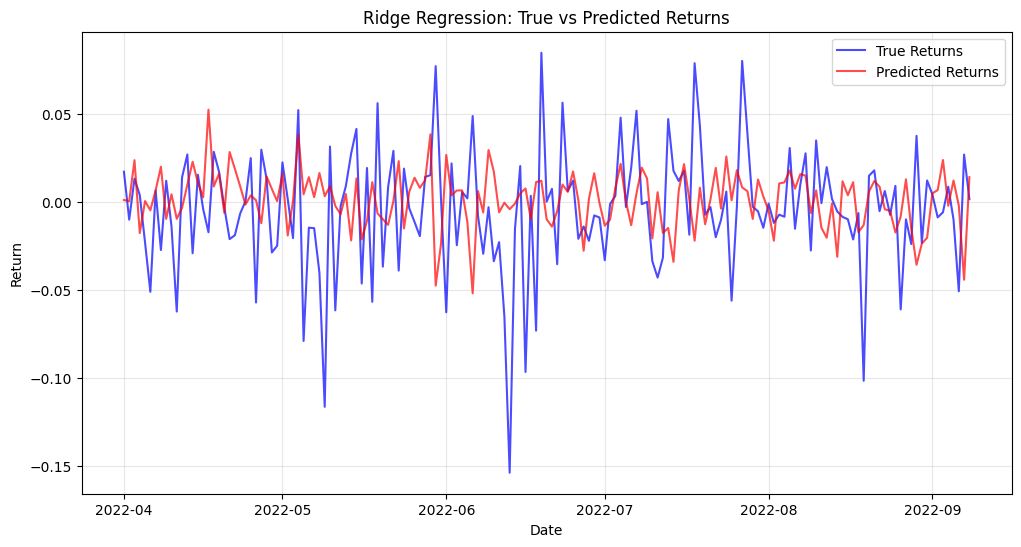

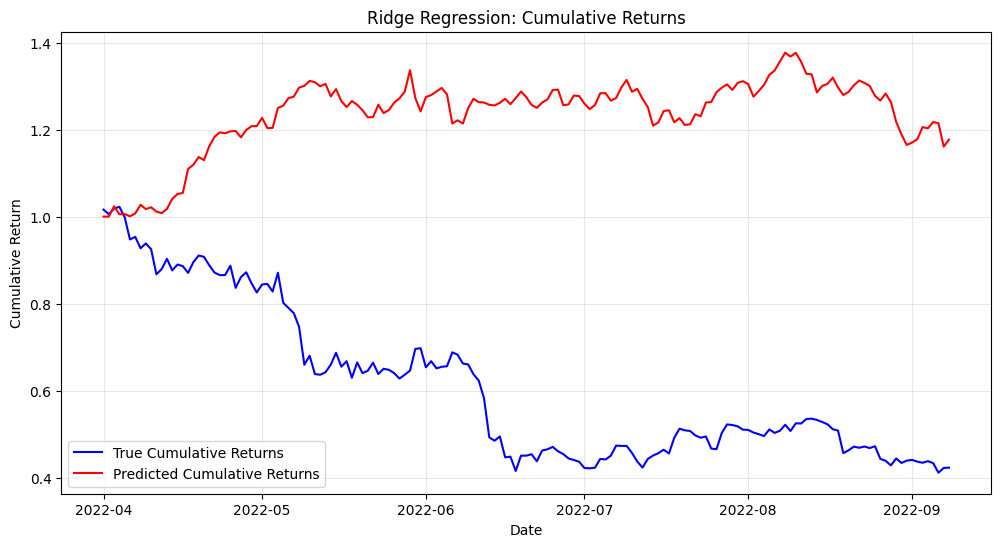

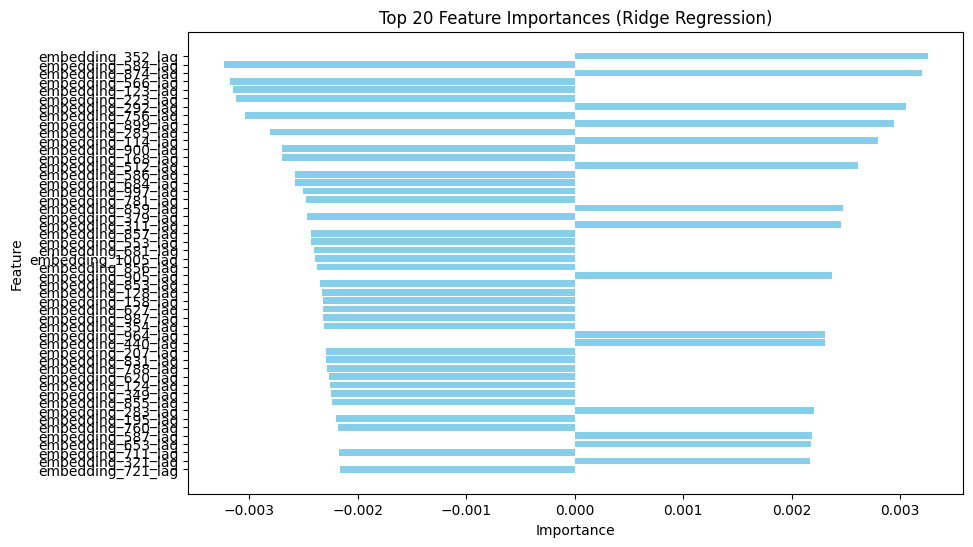

(Ridge(alpha=200), 200, 0.0015704641353008625, -0.29591409869452767)

In [15]:
ridge_regression(train_data, validate_data, test_data, alphas=[0.001, 0.01, 0.1, 1, 5, 10, 200])

### Non-Linear Models

#### Random Forest

In [14]:
train_set_end_date = '2021-12-31'
validation_set_end_date = '2022-3-31'

train_data = daily_embed_df[daily_embed_df['date'] <= train_set_end_date]
validate_data = daily_embed_df[(daily_embed_df['date'] > train_set_end_date) & (daily_embed_df['date'] <= validation_set_end_date)]
test_data = daily_embed_df[daily_embed_df['date'] > validation_set_end_date]

In [70]:
def random_forest(train_data, validate_data, test_data, 
                        n_estimators_list=[50, 100, 200], 
                        max_depth_list=[None, 5, 10, 15],
                        random_state=42):
    """
    Train a Random Forest model with grid search for hyperparameter tuning.
    
    Parameters:
    -----------
    train_data : DataFrame with 'return' as second column and features from third column onwards
    validate_data : DataFrame with same structure as train_data
    test_data : DataFrame with same structure as train_data
    n_estimators_list : list of integers for number of trees to try
    max_depth_list : list of max depth values to try
    random_state : int, random seed for reproducibility
    
    Returns:
    --------
    dict : Contains best model, parameters, and evaluation metrics
    """
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.metrics import mean_squared_error, r2_score
    import numpy as np
    import matplotlib.pyplot as plt
    import pandas as pd

    # Initialize tracking variables
    best_mse = float('inf')
    best_r2 = float('-inf')
    best_params = {}
    best_model = None

    # Prepare data
    X_train = train_data.iloc[:, 2:]
    y_train = train_data.iloc[:, 1]
    X_val = validate_data.iloc[:, 2:] 
    y_val = validate_data.iloc[:, 1]

    # Grid search for best hyperparameters
    for n_estimators in n_estimators_list:
        for max_depth in max_depth_list:
            rf_model = RandomForestRegressor(
                n_estimators=n_estimators, 
                max_depth=max_depth,
                random_state=random_state,
                n_jobs=-1
            )
            
            # Train the model
            rf_model.fit(X_train, y_train)
            
            # Predict on validation set
            y_val_pred = rf_model.predict(X_val)
            
            # Calculate metrics
            mse = mean_squared_error(y_val, y_val_pred)
            r2_val = r2_score(y_val, y_val_pred)
            
            print(f'n_estimators={n_estimators}, max_depth={max_depth}, MSE: {mse}, R^2: {r2_val}')
            
            if mse < best_mse:
                best_mse = mse
                best_r2 = r2_val
                best_params = {'n_estimators': n_estimators, 'max_depth': max_depth}
                best_model = rf_model

    print(f'\nBest parameters: {best_params}')
    print(f'Best MSE on validation set: {best_mse:.6f}')
    print(f'Corresponding R^2 on validation set: {best_r2:.6f}')

    # Evaluate on test data
    X_test = test_data.iloc[:, 2:]
    y_test = test_data.iloc[:, 1]
    y_test_pred = best_model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    print(f'Test MSE: {test_mse:.6f}, Test R^2: {test_r2:.6f}')

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['date'], y_test, label='True Returns', color='blue', alpha=0.7)
    plt.plot(test_data['date'], y_test_pred, label='Predicted Returns', color='red', alpha=0.7)
    plt.title('Random Forest: True vs Predicted Returns')
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Cumulative returns plot
    plt.figure(figsize=(12, 6))
    plt.plot(test_data['date'], np.cumprod(1+y_test), label='True Cumulative Returns', color='blue')
    plt.plot(test_data['date'], np.cumprod(1+y_test_pred), label='Predicted Cumulative Returns', color='red')
    plt.title('Random Forest: Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # Feature importance visualization
    feature_importances = best_model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    # Plot top features
    top_n = 20
    plt.figure(figsize=(10, 8))
    plt.barh(importance_df['Feature'].head(top_n), importance_df['Importance'].head(top_n), color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Top {top_n} Feature Importances (Random Forest)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return {
        'model': best_model,
        'best_params': best_params,
        'val_metrics': {'mse': best_mse, 'r2': best_r2},
        'test_metrics': {'mse': test_mse, 'r2': test_r2},
        'predictions': y_test_pred
    }

n_estimators=50, max_depth=None, MSE: 0.0005913540820922272, R^2: -0.11469140639105935
n_estimators=50, max_depth=5, MSE: 0.00054114104783186, R^2: -0.020040774098439407
n_estimators=50, max_depth=10, MSE: 0.0005524807670936962, R^2: -0.04141593323716464
n_estimators=50, max_depth=15, MSE: 0.000583144463691436, R^2: -0.09921642894821381
n_estimators=100, max_depth=None, MSE: 0.0005743721040354663, R^2: -0.08268069474361583
n_estimators=100, max_depth=5, MSE: 0.000541527959446891, R^2: -0.020770095270590705
n_estimators=100, max_depth=10, MSE: 0.0005467509446546318, R^2: -0.03061532489372576
n_estimators=100, max_depth=15, MSE: 0.0005726726977701661, R^2: -0.0794773456550375
n_estimators=200, max_depth=None, MSE: 0.0005656569104653471, R^2: -0.0662527175437706
n_estimators=200, max_depth=5, MSE: 0.0005388044956116616, R^2: -0.015636416777992324
n_estimators=200, max_depth=10, MSE: 0.0005454857770547357, R^2: -0.028230507583834274
n_estimators=200, max_depth=15, MSE: 0.000568325266633748

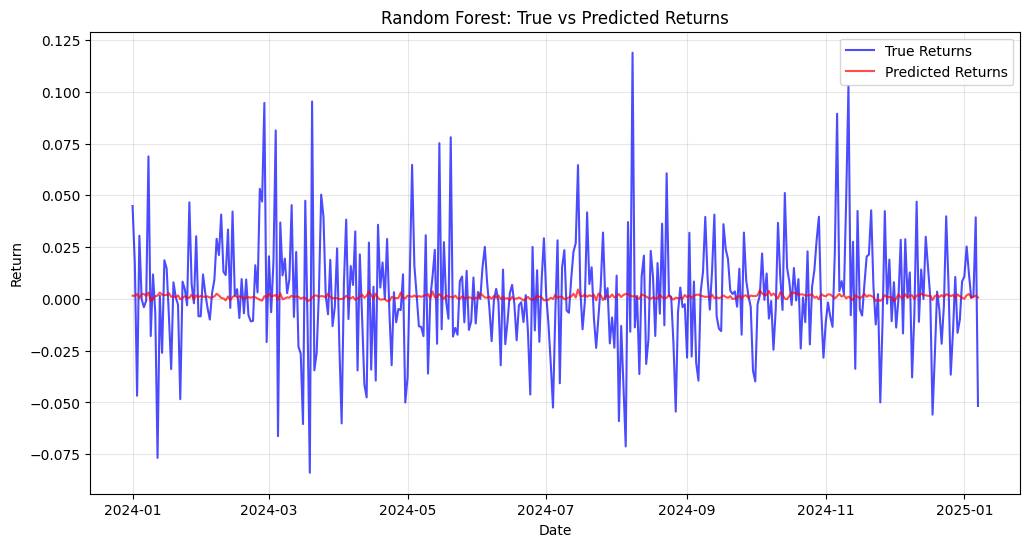

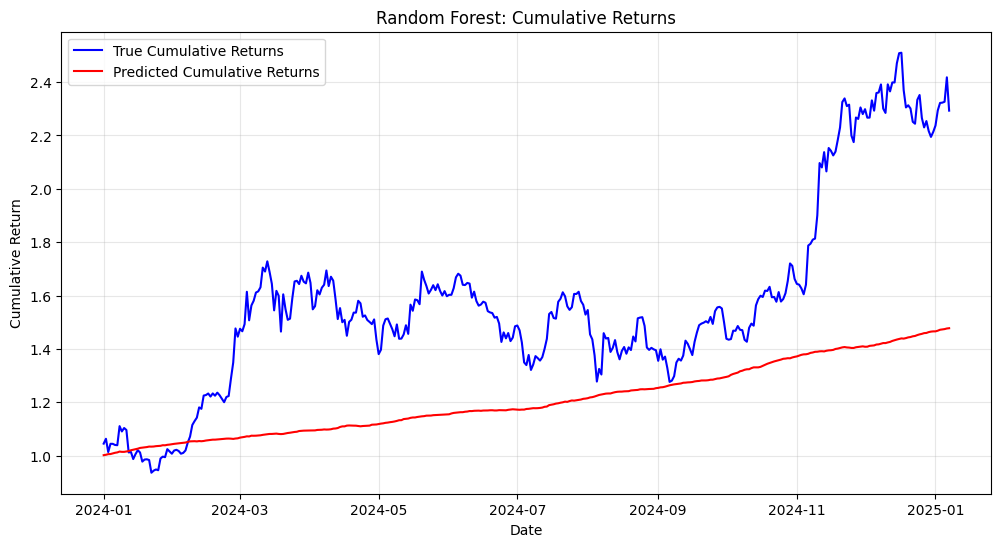

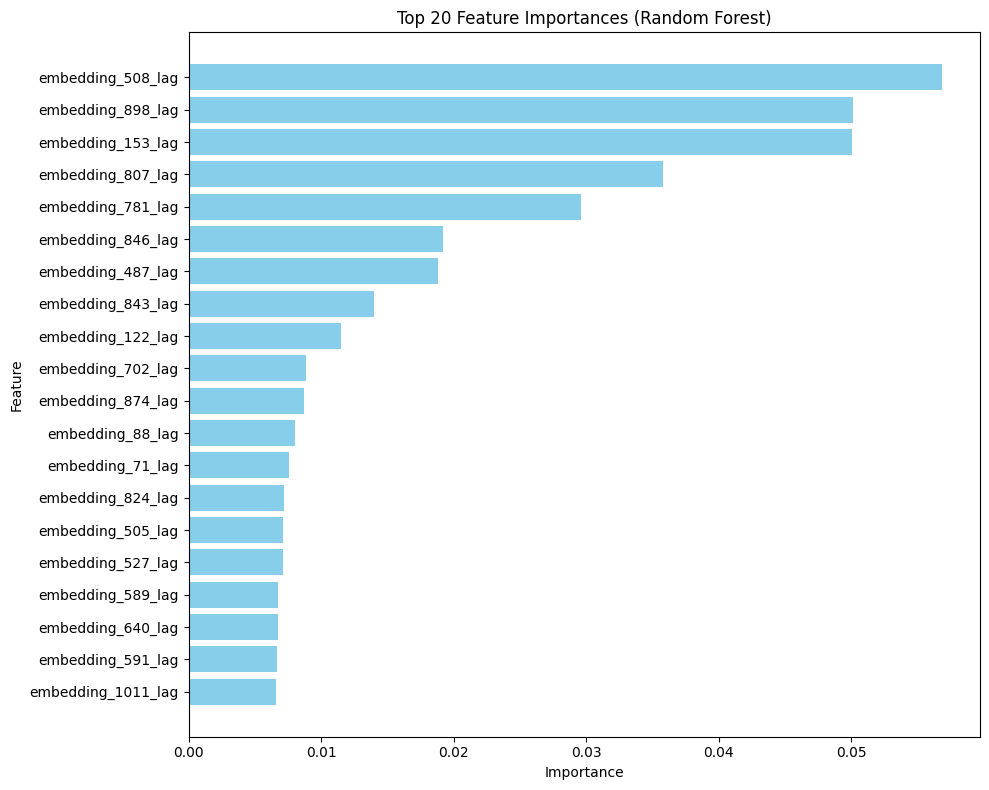

{'model': RandomForestRegressor(max_depth=5, n_estimators=200, n_jobs=-1, random_state=42),
 'best_params': {'n_estimators': 200, 'max_depth': 5},
 'val_metrics': {'mse': 0.0005388044956116616, 'r2': -0.015636416777992324},
 'test_metrics': {'mse': 0.00076738995375558, 'r2': 0.001602863313899694},
 'predictions': array([ 1.56009014e-03,  1.46770933e-03,  2.34992895e-03,  4.12213774e-04,
         2.25699104e-03,  2.39978043e-03,  1.41014837e-03,  3.13136204e-03,
        -1.08873514e-03, -1.11345469e-05,  1.26669784e-03,  1.63156791e-03,
         3.09277647e-03,  2.01762074e-03,  1.81794596e-03,  1.84863199e-03,
         2.78388367e-03,  9.77828590e-04,  1.36485688e-03,  7.89808525e-04,
         1.76104234e-03, -2.04437150e-04,  4.52787579e-04,  1.30548970e-03,
         7.24060769e-04,  5.12166638e-04,  2.10964707e-03, -2.39439870e-04,
         1.71117360e-03,  8.40221398e-04,  1.44972787e-03,  1.19217280e-03,
         8.85744387e-04,  1.22841015e-03,  6.14398192e-04,  7.92008185e-04,
  

In [71]:
random_forest(train_data, validate_data, test_data)

## Additional Data from Online

In [16]:
import os

data_path = '../Mikey_data/'
if os.path.exists(data_path):
    os.chdir(data_path)
    print('Changed directory to data path:', os.getcwd())
else:
    print('Data path does not exist:', data_path)

Changed directory to data path: /home/mfin7037_best_students/code/Mikey_data


In [17]:
import glob
from tqdm import tqdm
import pandas as pd
import gc

target_folder = 'jina_additional_data_embeddings'
parquet_files = glob.glob(os.path.join(target_folder, "*.parquet"))

mistral_embedding = pd.DataFrame()

for file in tqdm(parquet_files, desc=f"Loading files from {target_folder}"):
    df = pd.read_parquet(file)
    mistral_embedding = pd.concat([mistral_embedding, df], ignore_index=True)

# load news content
additional_news_df = pd.read_csv('news_currencies_source_joinedResult.csv')
additional_news_df.dropna(subset=['title'], inplace=True)
additional_news_df.rename(columns={'newsDatetime': 'date'}, inplace=True)

mistral_embedding.rename(columns={'jina_embeddings': 'mistral_embeddings'}, inplace=True)

# Merge the two DataFrames on the 'id' column
a_news_mistral_embed_df = pd.merge(additional_news_df, mistral_embedding, on='id', how='left')

# release memory
del additional_news_df
del mistral_embedding
gc.collect()

a_news_mistral_embed_df = a_news_mistral_embed_df[['id', 'date', 'title', 'mistral_embeddings', 'currencies']]

Loading files from jina_additional_data_embeddings: 100%|██████████| 88/88 [00:04<00:00, 20.38it/s]


In [18]:
print(f"Total rows: {len(a_news_mistral_embed_df)}")
# Filter the DataFrame to only include rows where 'currencies' contains 'BTC'
a_news_mistral_embed_df = a_news_mistral_embed_df[a_news_mistral_embed_df['currencies'].str.contains('BTC', na=False)]

# Display the filtered dataframe
print(f"Filtered rows with BTC: {len(a_news_mistral_embed_df)}")
a_news_mistral_embed_df

Total rows: 173979
Filtered rows with BTC: 22335


id                 date  \
12         887  2022-06-09 03:08:36   
17         892  2022-06-09 02:40:00   
24         900  2022-06-09 01:15:34   
32         911  2022-06-08 23:00:19   
33         912  2022-06-08 23:00:17   
...        ...                  ...   
173948  183645  2024-10-03 11:15:27   
173949  183646  2024-10-02 11:50:33   
173963  183660  2024-10-18 09:30:15   
173966  183663  2024-10-09 10:15:01   
173978  183676  2024-09-25 23:00:38   

                                                    title  \
12      TA: Bitcoin Stuck In Key Range, Why A Major Br...   
17      Bitcoin Trading Can Become Easier if You Follo...   
24      Gillibrand and Lummis state that most altcoins...   
32      U.S. Macro Pressure Responsible For Entire Bit...   
33      Shock And Awe: Bitcoin Lightning Network Capac...   
...                                                   ...   
173948  Latest data reveals global economic downturn, ...   
173949  Ten years of Bitcoin address data uncovers inv...   
173963  Behind Alchemy Pay and Yellow Card’s Bold Plan...   
173966  Alchemy Pay Expands Crypto Virtual Card to Sam...   
173978  Analysts remain divided on Q4 outlook despite ...   

                                       mistral_embeddings currencies  
12      [0.11342494189739227, -0.14031575620174408, -0...        BTC  
17      [0.11992566287517548, -0.14647269248962402, -0...        BTC  
24      [0.11887946724891663, -0.11657845973968506, -0...        BTC  
32      [0.12435568869113922, -0.12202109396457672, -0...        BTC  
33      [0.09865137934684753, -0.10893044620752335, -0...        BTC  
...                                                   ...        ...  
173948  [0.10719615966081619, -0.14156894385814667, -0...  BTC,ALPHA  
173949  [0.12657678127288818, -0.18272146582603455, -0...  BTC,ALPHA  
173963  [0.18473799526691437, -0.17978546023368835, 0....    BTC,ACH  
173966  [0.1478402018547058, -0.05915471911430359, 0.0...    BTC,ACH  
173978  [0.1140340268611908, -0.10139922052621841, -0....     BTC,MV  

[22335 rows x 5 columns]

In [194]:
import numpy as np

def convert_embedding_string(embed_str):
    # Remove brackets and split by comma
    values = embed_str.strip('[]').split(',')
    # Convert to float and handle whitespace
    return np.array([np.float64(val.strip()) for val in values])

# Apply to your column
a_news_mistral_embed_df['mistral_embeddings'] = a_news_mistral_embed_df['mistral_embeddings'].apply(convert_embedding_string)

In [195]:
# ready to merge btc daily return
btc_daily = pd.read_pickle('btc_daily.pkl')
btc_daily.reset_index(inplace=True)

# some processing
btc_daily.rename(columns={'Open time': 'date'}, inplace=True)
btc_daily.sort_values(by='date', inplace=True)
btc_daily['return'] = np.log(1 + btc_daily['Close'].pct_change())

# btc_daily['return_signal'] = btc_daily['Close'].pct_change().apply(lambda x: 1 if x > 0 else -1)

a_news_mistral_embed_df['date'] = pd.to_datetime(a_news_mistral_embed_df['date'])
a_news_mistral_embed_df['date'] = a_news_mistral_embed_df['date'].dt.normalize()
btc_daily['date'] = btc_daily['date'].dt.normalize()

a_mistral_embedding_btc_df = pd.merge(
    a_news_mistral_embed_df,
    btc_daily,
    on='date',
    how='inner'
)

a_mistral_embedding_btc_df

id       date                                              title  \
0         887 2022-06-09  TA: Bitcoin Stuck In Key Range, Why A Major Br...   
1         892 2022-06-09  Bitcoin Trading Can Become Easier if You Follo...   
2         900 2022-06-09  Gillibrand and Lummis state that most altcoins...   
3         911 2022-06-08  U.S. Macro Pressure Responsible For Entire Bit...   
4         912 2022-06-08  Shock And Awe: Bitcoin Lightning Network Capac...   
...       ...        ...                                                ...   
22330  183645 2024-10-03  Latest data reveals global economic downturn, ...   
22331  183646 2024-10-02  Ten years of Bitcoin address data uncovers inv...   
22332  183660 2024-10-18  Behind Alchemy Pay and Yellow Card’s Bold Plan...   
22333  183663 2024-10-09  Alchemy Pay Expands Crypto Virtual Card to Sam...   
22334  183676 2024-09-25  Analysts remain divided on Q4 outlook despite ...   

                                      mistral_embeddings currencies      Open  \
0      [0.11342494189739227, -0.14031575620174408, -0...        BTC  30204.77   
1      [0.11992566287517548, -0.14647269248962402, -0...        BTC  30204.77   
2      [0.11887946724891663, -0.11657845973968506, -0...        BTC  30204.77   
3      [0.12435568869113922, -0.12202109396457672, -0...        BTC  31125.32   
4      [0.09865137934684753, -0.10893044620752335, -0...        BTC  31125.32   
...                                                  ...        ...       ...   
22330  [0.10719615966081619, -0.14156894385814667, -0...  BTC,ALPHA  60649.27   
22331  [0.12657678127288818, -0.18272146582603455, -0...  BTC,ALPHA  60804.92   
22332  [0.18473799526691437, -0.17978546023368835, 0....    BTC,ACH  67421.78   
22333  [0.1478402018547058, -0.05915471911430359, 0.0...    BTC,ACH  62160.50   
22334  [0.1140340268611908, -0.10139922052621841, -0....     BTC,MV  64262.70   

           High       Low     Close       Volume              Close time  \
0      30700.00  29944.10  30109.93  46291.18650 2022-06-09 23:59:59.999   
1      30700.00  29944.10  30109.93  46291.18650 2022-06-09 23:59:59.999   
2      30700.00  29944.10  30109.93  46291.18650 2022-06-09 23:59:59.999   
3      31327.22  29843.88  30204.77  68542.61276 2022-06-08 23:59:59.999   
4      31327.22  29843.88  30204.77  68542.61276 2022-06-08 23:59:59.999   
...         ...       ...       ...          ...                     ...   
22330  61477.19  59828.11  60752.71  26221.43472 2024-10-03 23:59:59.999   
22331  62390.31  60000.00  60649.28  31534.70118 2024-10-02 23:59:59.999   
22332  69000.00  67192.36  68428.00  28725.63500 2024-10-18 23:59:59.999   
22333  62543.75  60301.00  60636.02  20011.15684 2024-10-09 23:59:59.999   
22334  64817.99  62947.08  63152.01  17813.11168 2024-09-25 23:59:59.999   

       Quote volume   Trades  Taker buy base     Taker buy quote Ignore  \
0      1.399839e+09   841562  23082.29251000  697948605.98846330      0   
1      1.399839e+09   841562  23082.29251000  697948605.98846330      0   
2      1.399839e+09   841562  23082.29251000  697948605.98846330      0   
3      2.087270e+09  1236327  32668.41005000  995180478.27453850      0   
4      2.087270e+09  1236327  32668.41005000  995180478.27453850      0   
...             ...      ...             ...                 ...    ...   
22330  1.590774e+09  5244004  12906.51464000  783073701.73311730      0   
22331  1.928378e+09  5313210  15719.32519000  961468320.51547270      0   
22332  1.959736e+09  4010969  14218.17850000  970440964.26681170      0   
22333  1.234779e+09  3668363   9454.70171000  583725546.03098850      0   
22334  1.135251e+09  3355531   8384.67983000  534590429.21054930      0   

         return  
0     -0.003145  
1     -0.003145  
2     -0.003145  
3     -0.030022  
4     -0.030022  
...         ...  
22330  0.001704  
22331 -0.002577  
22332  0.014814  
22333 -0.024830  
22334 -0.017435  

[22335 rows x 17 columns]

In [196]:
import numpy as np

daily_embed_df = (
    a_mistral_embedding_btc_df
    .groupby('date')
    .apply(
        lambda g: pd.Series(
            {
                # because group, pick last row return
                'return': g['return'].iloc[-1],
                # 'return_signal': g['return_signal'].iloc[-1],
                
                # take the average of each positions (index) of embeddings, each day
                'embedding': np.mean(np.stack(g['mistral_embeddings'].values), axis=0) 
            }
        )
    )
).reset_index()

# lag embedding
daily_embed_df['embedding_lag'] = daily_embed_df['embedding'].shift(1)
daily_embed_df = daily_embed_df.drop(index=0, columns='embedding').reset_index(drop=True)

/tmp/ipykernel_1217854/3338574687.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [197]:
# expand the 'embedding' column into separate columns
expanded_df = pd.DataFrame(
    daily_embed_df['embedding_lag'].tolist(), 
    columns=[f'embedding_{i}_lag' for i in range(len(daily_embed_df['embedding_lag'][0]))]
)

daily_embed_df = pd.concat([daily_embed_df.drop(columns=['embedding_lag']), expanded_df], axis=1)

daily_embed_df

date    return  embedding_0_lag  embedding_1_lag  embedding_2_lag  \
0    2017-10-31  0.054450         0.098891        -0.134438        -0.055407   
1    2017-11-12 -0.072031         0.220634        -0.108687        -0.027134   
2    2017-11-13  0.106798         0.111227        -0.159233        -0.062155   
3    2017-11-14  0.016717         0.211917        -0.109288        -0.049164   
4    2017-11-20  0.021416         0.190510        -0.141292        -0.004537   
...         ...       ...              ...              ...              ...   
1636 2025-01-03  0.012189         0.128840        -0.127259        -0.073804   
1637 2025-01-04  0.000472         0.138407        -0.131428        -0.073661   
1638 2025-01-05  0.001456         0.128851        -0.137311        -0.085293   
1639 2025-01-06  0.038609         0.126008        -0.133857        -0.075211   
1640 2025-01-07 -0.053037         0.130563        -0.132686        -0.076212   

      embedding_3_lag  embedding_4_lag  embedding_5_lag  embedding_6_lag  \
0           -0.105534         0.108639         0.019721         0.077228   
1           -0.033915         0.049955        -0.038067         0.082052   
2           -0.018542         0.087110         0.021261         0.031216   
3           -0.086882         0.062390         0.032617         0.044391   
4           -0.035995         0.071766         0.073502         0.030703   
...               ...              ...              ...              ...   
1636        -0.043567         0.071354         0.009890         0.008417   
1637        -0.036591         0.062489        -0.005256         0.005347   
1638        -0.062487         0.073252         0.000630         0.001912   
1639        -0.050717         0.066650        -0.001095         0.005472   
1640        -0.047213         0.069956        -0.000932         0.005395   

      embedding_7_lag  ...  embedding_1014_lag  embedding_1015_lag  \
0            0.121813  ...            0.013073            0.003930   
1            0.077307  ...           -0.031621            0.009147   
2            0.086976  ...            0.000985           -0.013114   
3            0.117134  ...           -0.035410            0.008305   
4            0.121339  ...           -0.021179            0.003728   
...               ...  ...                 ...                 ...   
1636         0.072480  ...           -0.004065            0.003611   
1637         0.069441  ...           -0.002891            0.004385   
1638         0.072516  ...           -0.003503            0.001200   
1639         0.076038  ...            0.000608           -0.001495   
1640         0.064300  ...            0.000936            0.005604   

      embedding_1016_lag  embedding_1017_lag  embedding_1018_lag  \
0               0.010564           -0.014989           -0.026335   
1              -0.002874           -0.021413           -0.003361   
2               0.002524           -0.024954           -0.035503   
3              -0.026457           -0.013791            0.001735   
4              -0.023956           -0.026939           -0.006933   
...                  ...                 ...                 ...   
1636           -0.006890           -0.015438            0.004662   
1637           -0.008821           -0.017510           -0.000148   
1638           -0.006589           -0.018906            0.005532   
1639           -0.004851           -0.017929            0.002483   
1640           -0.000416           -0.015811           -0.000976   

      embedding_1019_lag  embedding_1020_lag  embedding_1021_lag  \
0              -0.027470           -0.011563           -0.005740   
1              -0.020410           -0.005399           -0.032931   
2              -0.044340           -0.005945            0.009143   
3              -0.006713           -0.009821           -0.031586   
4              -0.016575           -0.016375           -0.017136   
...                  ...                 ...                 ...   
163

In [202]:
train_set_end_date = '2024-6-30'
validation_set_end_date = '2024-9-30'

train_data = daily_embed_df[daily_embed_df['date'] <= train_set_end_date]
validate_data = daily_embed_df[(daily_embed_df['date'] > train_set_end_date) & (daily_embed_df['date'] <= validation_set_end_date)]
test_data = daily_embed_df[daily_embed_df['date'] > validation_set_end_date]

alpha = 0.001, MSE: 0.001655491960287212, R^2 (Validation): -1.139800051542609
alpha = 0.01, MSE: 0.0016296180891612543, R^2 (Validation): -1.106356874470746
alpha = 0.1, MSE: 0.0015535938585656288, R^2 (Validation): -1.0080920345020976
alpha = 1, MSE: 0.0012967112539778224, R^2 (Validation): -0.6760593676433446
alpha = 5, MSE: 0.0010686536554533885, R^2 (Validation): -0.3812843564783228
alpha = 10, MSE: 0.0009837624706015944, R^2 (Validation): -0.2715585673601033
alpha = 200, MSE: 0.0008046581471685793, R^2 (Validation): -0.04005793207645003
Best alpha (penalty level): 200
Best MSE on validation set: 0.000805
Corresponding R^2 on Validation Set: -0.040058
Test MSE: 0.0007789650348186536, Test R^2: -0.2142906929397912


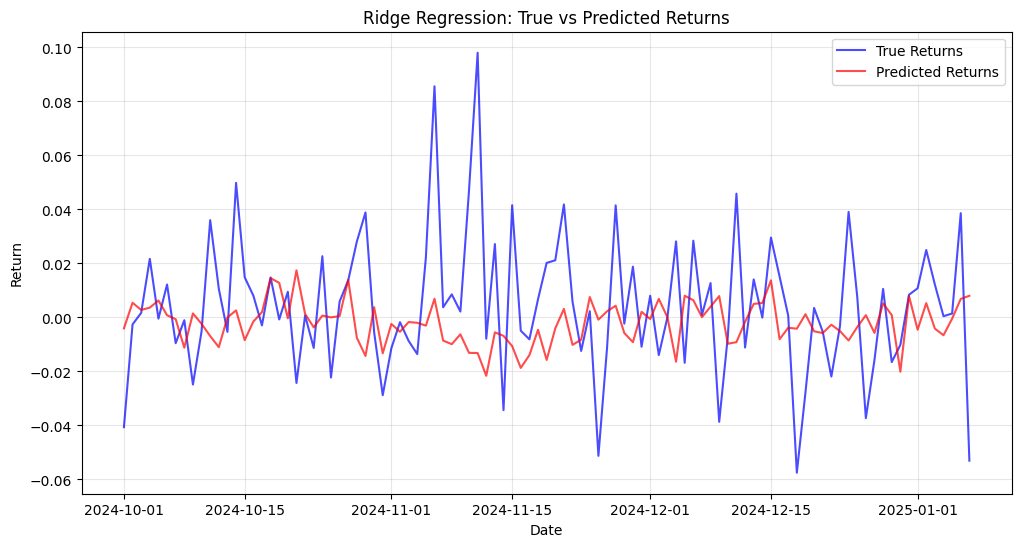

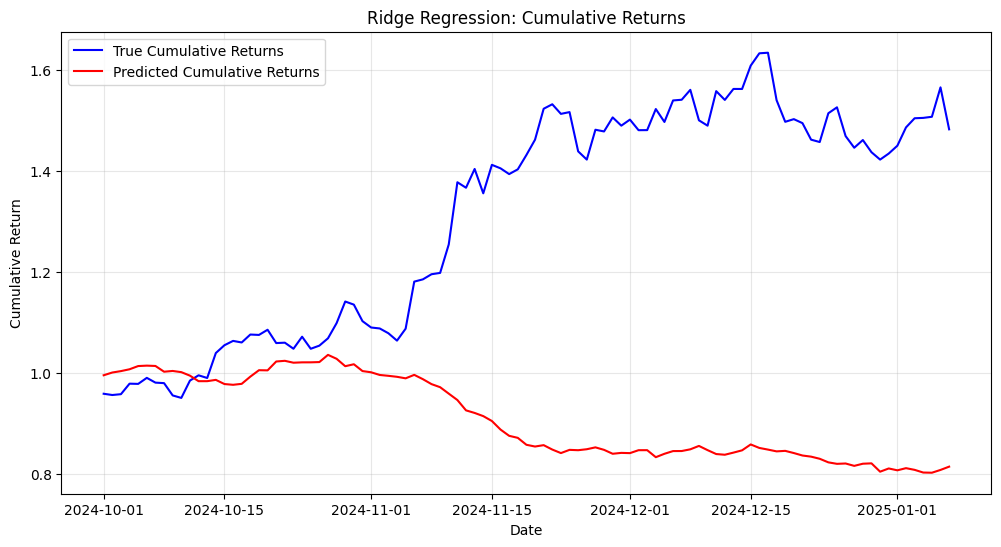

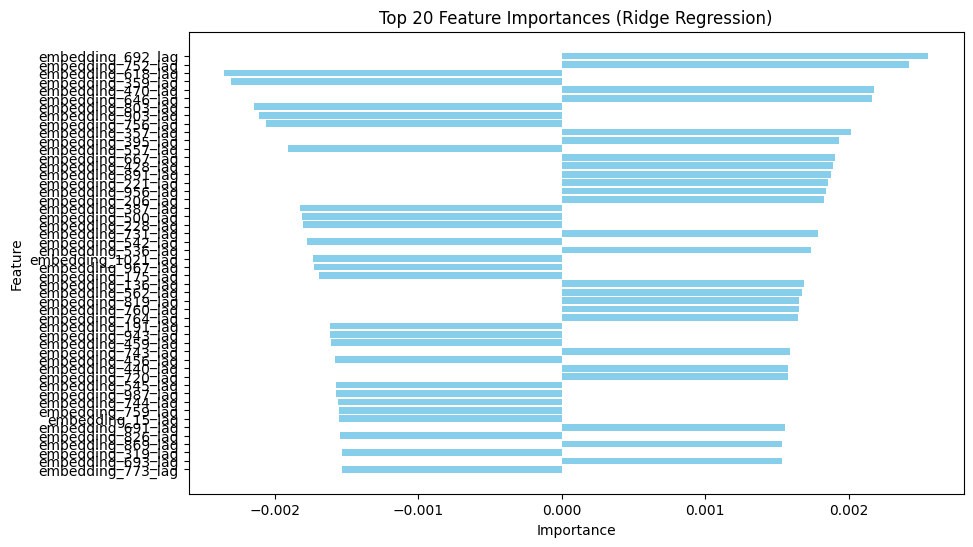

(Ridge(alpha=200), 200, 0.0007789650348186536, -0.2142906929397912)

In [204]:
ridge_regression(train_data, validate_data, test_data, alphas=[0.001, 0.01, 0.1, 1, 5, 10, 200])

In [ ]:
random_forest(train_data, validate_data, test_data)

In [133]:
from sklearn.linear_model import RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

def ridge_classification(train_data, validate_data, test_data, alphas):
    """
    Perform Ridge regression with hyperparameter tuning and evaluate on test data.

    Parameters:
    - train_data: DataFrame containing training data
    - validate_data: DataFrame containing validation data
    - test_data: DataFrame containing test data
    - alphas: List of alpha values (regularization strength) to tune
    - target_col: Name of the target column (default is 'return')

    Returns:
    - best_model: Trained Ridge model with the best alpha
    - best_alpha: Best alpha value
    - test_mse: Mean squared error on the test set
    - test_r2: R^2 score on the test set
    """
    # Split features and target
    # Prepare data
    X_train = train_data.iloc[:, 2:]
    y_train = train_data.iloc[:, 1]
    X_val = validate_data.iloc[:, 2:] 
    y_val = validate_data.iloc[:, 1]
    X_test = test_data.iloc[:, 2:]
    y_test = test_data.iloc[:, 1]

    # Initialize tracking variables
    best_alpha = None
    best_accuracy = 0
    best_model = None

    # Hyperparameter tuning
    for alpha_val in alphas:
        clf = RidgeClassifier(alpha=1.0)
        clf.fit(X_train, y_train)

        # Predict on validation set
        y_val_pred = clf.predict(X_val)

        # Evaluate
        val_accuracy = accuracy_score(y_val, y_val_pred)

        print(f'Validation accuracy: {val_accuracy:.4f}')

        if val_accuracy > best_accuracy:
            best_alpha = alpha_val
            best_model = clf

    # Test set performance
    y_test_pred = clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy: {test_accuracy:.4f}')
    print(classification_report(y_test, y_test_pred))

    return best_model, best_alpha

In [135]:
ridge_classification(train_data, validate_data, test_data, alphas=[0.001, 0.01, 0.1, 1, 5, 10])

Validation accuracy: 0.5342
Validation accuracy: 0.5342
Validation accuracy: 0.5342
Validation accuracy: 0.5342
Validation accuracy: 0.5342
Validation accuracy: 0.5342
Test accuracy: 0.5174
              precision    recall  f1-score   support

          -1       0.48      0.33      0.39       175
           1       0.54      0.69      0.60       198

    accuracy                           0.52       373
   macro avg       0.51      0.51      0.49       373
weighted avg       0.51      0.52      0.50       373



(RidgeClassifier(), 10)